# Figure 7: Probability of outbreak versus threshold of concurrent infections

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

### Importing required libraries

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
from scipy.optimize import fsolve
import multiprocessing as mp
import timeit

### Importing required scripts

In [2]:
import importlib
import Gillespie_household_full
import R_star_construct

importlib.reload(Gillespie_household_full)
importlib.reload(R_star_construct)

do_Gillespie = Gillespie_household_full.do_Gillespie
RstarAnal = R_star_construct.RstarAnal

### Parameters

In [3]:
h1,h2 = 2520,2520            # no. of households in each neighbourhood
n1,n2 = 2,2                  # size of households for each neighbourhood
Inf1,Inf2 = 1,0              # initial no. of infections in each neighbourhood
gamma = 0.2                  # recovery rate from infection
days = 100                   # no. of days in simulation
tStart, tEnd = 0, days       # start time and end time (days) of simulation
time_points = np.linspace(tStart, tEnd, days+1)  # time points for Gillespie output, daily
chains = 10000

In [4]:
nu = 3      # good range 1 to 6 (2 to 4)
beta = fsolve(RstarAnal,0.5,(gamma,nu))[0]
alpha = beta/nu

alpha=round(alpha,2)
beta=round(beta,2)
alpha,beta

(0.27, 0.8)

In [5]:
## constructing rho

N_neigh = 2               # no. of neighbourhoods
H = np.array([h1,h2])     # array of number of households in each neighbourhood
N = np.array([n1,n2])     # array of household size for each neighbourhood

p_reserve = np.array([0,0])            # proportion of contacts reserved for own neighbourhood
rho = np.zeros((N_neigh,N_neigh))      # initialising array to store rho values

for i in range(N_neigh): 
    for j in range(N_neigh):
        rho[i,j] = (1-p_reserve[i])*(1-p_reserve[j])*H[j]*N[j]/(np.sum((1-p_reserve)*H*N))
    rho[i,i] = p_reserve[i] + (1-p_reserve[i])*(1-p_reserve[i])*H[i]*N[i]/(np.sum((1-p_reserve)*H*N))

### Running 10,000 full sims
*Make sure to remove any conditions that stop the simulation early, other than there being no infectious individuals left.*

In [6]:
pool = mp.Pool(mp.cpu_count())    # start paralellization
t1 = timeit.default_timer()       # start timer

params_dict = {'beta': [beta, beta],      # parameter dictionary input into SSA
               'alpha': alpha*rho, 
               'gamma':gamma,
               'n': [n1,n2], 
               'h': [h1,h2],
               'inf0':[Inf1, Inf2],
               'tStart':tStart,
               'tEnd':tEnd,
               'time_points':time_points
              }

out1 = pool.map(do_Gillespie, [params_dict for i in range(chains)])   # records output of sims

pool.close()    # end paralellization
print('Time to run:', timeit.default_timer() - t1)   # print how long took

Time to run: 2935.6704577


### Recording the results

In [7]:
outbreak1 = np.zeros(chains)  # initialise array to store outbreak sizes

for i in range(chains):   # find the outbreak sizes (in terms of households) and record
    ind_infs = np.max(np.hstack((np.nonzero(out1[i][:,0]), np.nonzero(out1[i][:,1]))))
    outbreak1[i] = np.sum(out1[i][ind_infs,:])

In [8]:
k_thresh = np.arange(1,16,1)               # list of possible thresholds of infections
prob_epi = np.zeros(len(k_thresh))  # initialise array to store probability of outbreak for each threshold

for k in range(len(k_thresh)):   # loop over thresholds
    correct = 0                  # initialise counters
    jinfs = 0
    for i in range(chains):
        hhold_infs = out1[i]     # unpacking no. of households infected
     
        for j in range(len(time_points)):                   # looping over time points  for each run
            if (np.sum(hhold_infs[j,:]) >= k_thresh[k]):    # if reach threshold number of infections
                jinfs += 1                                  # count
                if outbreak1[i] > 15:            # if total outbreak is larger than 15 households say
                    correct += 1                 # count as correct
                    break
            
    prob_epi[k] = correct/jinfs    # prob of epidemic is no. of correct obs/ total no. of times threshold met
k_thresh,prob_epi

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([0.39280115, 0.5816156 , 0.70421585, 0.80276817, 0.86483501,
        0.90874801, 0.93983496, 0.96088357, 0.97691828, 0.98988622,
        0.99507546, 0.99761108, 0.99920242, 0.9995213 , 1.        ]))

### Producing figure

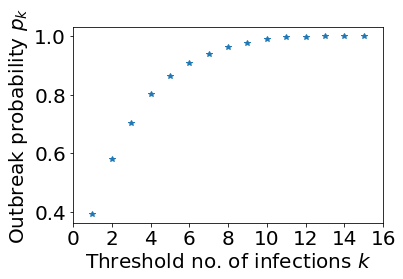

In [15]:
## Plot outbreak probability vs thresholds of infections
plt.rcParams.update({'font.size': 20})
plt.plot(k_thresh,prob_epi,'*')
plt.xticks([0,2,4,6,8,10,12,14,16])
plt.xlabel('Threshold no. of infections $k$')
plt.ylabel(r'Outbreak probability $p_k$')
plt.tight_layout()
plt.savefig('identifiers.pdf')